In [0]:
!pip install kornia

     |████████████████████████████████| 163kB 4.7MB/s 


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from scipy import io 
import torch.utils.data
import scipy
from scipy.stats import entropy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
from sklearn.metrics import mean_squared_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
!pip install -U spectral
!pip install pytorch_ssim
from pytorch_ssim import ssim

if not (os.path.isfile('/content/Salinas_corrected.mat')):
  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
if not (os.path.isfile('/content/Salinas_gt.mat')):
  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat


     |████████████████████████████████| 194kB 5.0MB/s 
  Created wheel for pytorch-ssim: filename=pytorch_ssim-0.1-cp36-none-any.whl size=2027 sha256=a0a3d1a8ecf577b3d1acecbf082b4c3c618efd8ee14dfdd35886627036c2354a
  Stored in directory: /root/.cache/pip/wheels/86/60/c8/85a73ea90dcf1d39d5d7f94d83988511f0370229dee641bb79
Successfully built pytorch-ssim
--2020-04-30 19:38:29--  https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gokriznastic/HybridSN/master/data/Salinas_corrected.mat [following]
--2020-04-30 19:38:30--  https://raw.githubusercontent.com/gokriznastic/HybridSN/master/data/Salinas_corrected.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubus

In [0]:
from torch.nn import Module, Sequential, Conv2d, ReLU,AdaptiveMaxPool2d, AdaptiveAvgPool2d, \
    NLLLoss, BCELoss, CrossEntropyLoss, AvgPool2d, MaxPool2d, Parameter, Linear, Sigmoid, Softmax, Dropout, Embedding
from torch.nn import functional as F

In [0]:
import scipy.io as sio
def loadData():
    
    data = sio.loadmat('Salinas_corrected.mat')['salinas_corrected']
    labels = sio.loadmat('Salinas_gt.mat')['salinas_gt']
    
    return data, labels

In [0]:
def padWithZeros(X, margin=2):

    ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):

     ## From: https://github.com/gokriznastic/HybridSN/blob/master/Hybrid-Spectral-Net.ipynb
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]), dtype=np.uint8)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]), dtype=np.uint8)
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels


In [0]:
class HyperSpectralDataset(Dataset):
    """HyperSpectral dataset."""

    def __init__(self,data_url,label_url):
        
        self.data = np.array(scipy.io.loadmat('/content/'+data_url.split('/')[-1])['salinas_corrected'])
        self.targets = np.array(scipy.io.loadmat('/content/'+label_url.split('/')[-1])['salinas_gt'])
        self.data, self.targets = createImageCubes(self.data,self.targets, windowSize=5)
        
        
        self.data = torch.Tensor(self.data)
        self.data = self.data.permute(0,3,1,2)
        print(self.data.shape)
        

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
      
      return self.data[idx,:,:,:] , self.targets[idx]


In [0]:
data_train = HyperSpectralDataset('Salinas_corrected.mat','Salinas_gt.mat')
train_loader = DataLoader(data_train, batch_size=16, shuffle=True)

torch.Size([54129, 204, 5, 5])


In [0]:
print(data_train.__getitem__(0)[0].shape)
print(data_train.__len__())

torch.Size([204, 5, 5])
54129


In [0]:
class PAM_Module(Module):
    """ Position attention module  https://github.com/junfu1115/DANet/blob/master/encoding/nn/attention.py"""
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        
        self.gamma = Parameter(torch.zeros(1))

        self.softmax = Softmax(dim=-1)
    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        #out = F.avg_pool2d(out, out.size()[2:4])
        
        return out


class CAM_Module(Module):
    """ Channel attention module https://github.com/junfu1115/DANet/blob/master/encoding/nn/attention.py"""
    def __init__(self):
        super(CAM_Module, self).__init__()
        #self.chanel_in = in_dim
        


        self.gamma = Parameter(torch.zeros(1))
        self.softmax  = Softmax(dim=-1)
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        """
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key = x.view(m_batchsize, C, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention = self.softmax(energy_new)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        #out = F.avg_pool2d(out, out.size()[2:4])
        
        
        return out


In [0]:
class RecNet(nn.Module):
    def __init__(self):
        super(RecNet, self).__init__()
        self.conv3d_1 = nn.Sequential(nn.Conv3d(1, 128, (1, 3, 3), 1), 
                        nn.BatchNorm3d(128),
                        nn.PReLU())
        
        self.conv3d_2 = nn.Sequential(nn.Conv3d(128, 64, (1, 3, 3), 1),
                        nn.BatchNorm3d(64),
                        nn.PReLU())
                        
        
        self.pool3d = nn.MaxPool3d((1, 1, 1), (1, 1, 1))
        
        self.deconv3d_1 = nn.Sequential(nn.ConvTranspose3d(64, 128, (1, 3, 3), 1),
                          nn.BatchNorm3d(128),
                          nn.PReLU())
        
        self.deconv3d_2 = nn.Sequential(nn.ConvTranspose3d(128, 1, (1, 3, 3), 1),
                          nn.BatchNorm3d(1))
        

    def forward(self, x):
        x = self.conv3d_1(x)
        x = self.conv3d_2(x)
        
        x = self.pool3d(x)
        
        x = self.deconv3d_1(x)
        x = self.deconv3d_2(x)
        
        
        return x.squeeze(1)

In [0]:
class DANet(Module):
  def __init__(self):
    super(DANet,self).__init__()
    self.PAM_Module = PAM_Module(204)
    self.CAM_Module = CAM_Module()
    self.RecNet = RecNet()
  def forward(self,x):
    
    P = self.PAM_Module(x)
    C = self.CAM_Module(x)
    #B,Ch,H,W = P.size()
    J = P + C
    J =  J.unsqueeze(1)
    ret = self.RecNet(J)
    
    
    
    return ret
    
    
danet_model = DANet().to(device)

In [0]:

from torchsummary import summary
summary(danet_model,input_size=(204,5,5))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 25, 5, 5]           5,125
            Conv2d-2             [-1, 25, 5, 5]           5,125
           Softmax-3               [-1, 25, 25]               0
            Conv2d-4            [-1, 204, 5, 5]          41,820
        PAM_Module-5            [-1, 204, 5, 5]               0
           Softmax-6             [-1, 204, 204]               0
        CAM_Module-7            [-1, 204, 5, 5]               0
            Conv3d-8       [-1, 128, 204, 3, 3]           1,280
       BatchNorm3d-9       [-1, 128, 204, 3, 3]             256
            PReLU-10       [-1, 128, 204, 3, 3]               1
           Conv3d-11        [-1, 64, 204, 1, 1]          73,792
      BatchNorm3d-12        [-1, 64, 204, 1, 1]             128
            PReLU-13        [-1, 64, 204, 1, 1]               1
        MaxPool3d-14        [-1, 64, 20

In [0]:
!nvidia-smi

Tue Apr 21 07:04:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    76W / 149W |    650MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
#model = BSNET_Conv().to(device) 

optimizer = optim.SGD(danet_model.parameters(), lr=0.005, momentum=0.9)optimizer = optim.SGD(danet_model.parameters(), lr=0.005, momentum=0.9)

In [0]:
top = 20

In [0]:
import skimage
import kornia
global bsnlist
ssim = kornia.losses.SSIM(5, reduction='none')
psnr = kornia.losses.PSNRLoss(2500)
from skimage import measure
ssim_list = []
psnr_list = []
l1_list = []
channel_weight_list = []
def train(epoch):    
    danet_model.train()
    ENTROPY = torch.zeros(204)
    
    for batch_idx, (data, __) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = danet_model(data)
        loss = F.l1_loss(output,data)
        loss.backward()
        optimizer.step()
        D = output.detach().cpu().numpy()
        for i in range(0,204):

          ENTROPY[i]+=skimage.measure.shannon_entropy(D[:,i,:,:])
        
        if batch_idx % (0.5*len(train_loader)) == 0:



            L1 = loss.item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),L1))
            l1_list.append(L1)
            ssim_val = torch.mean(ssim(data,output))
            print("SSIM: {}".format(ssim_val))
            ssim_list.append(ssim_val)
            psnr_val = psnr(data,output)
            print("PSNR: {}".format(psnr_val))
            psnr_list.append(psnr_val)
        
        
    ENTROPY = np.array(ENTROPY)
    bsnlist = np.asarray(ENTROPY.argsort()[-top:][::-1])
    print('Top {} bands with Entropy ->'.format(top),list(bsnlist))
    
    


for epoch in range(0, 10):
    train(epoch)
    

Train Epoch: 0 [0/54129 (0%)]	Loss: 119.193359
SSIM: 0.4998215436935425
PSNR: 25.01896095275879
Train Epoch: 0 [27072/54129 (50%)]	Loss: 53.677807
SSIM: 0.28785812854766846
PSNR: 30.45496940612793
Top 20 bands with Entropy -> [35, 50, 107, 148, 119, 118, 200, 12, 30, 53, 201, 198, 149, 46, 33, 95, 63, 27, 86, 51]
Train Epoch: 1 [0/54129 (0%)]	Loss: 6.626010
SSIM: 0.030591454356908798
PSNR: 47.226749420166016
Train Epoch: 1 [27072/54129 (50%)]	Loss: 3.235692
SSIM: 0.02992197312414646
PSNR: 56.14051818847656
Top 20 bands with Entropy -> [87, 119, 67, 31, 100, 47, 23, 12, 42, 27, 21, 55, 96, 26, 116, 40, 98, 22, 74, 123]
Train Epoch: 2 [0/54129 (0%)]	Loss: 2.486887
SSIM: 0.024928806349635124
PSNR: 58.09257507324219
Train Epoch: 2 [27072/54129 (50%)]	Loss: 2.271365
SSIM: 0.0237718615680933
PSNR: 59.152278900146484
Top 20 bands with Entropy -> [38, 31, 41, 59, 36, 51, 60, 97, 123, 54, 22, 150, 39, 35, 69, 175, 15, 26, 96, 63]
Train Epoch: 3 [0/54129 (0%)]	Loss: 4.208509
SSIM: 0.027006527408

In [0]:
x,xx,xxx = psnr_list,ssim_list,l1_list
print(len(x)),print(len(xx)),print(len(xxx))
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

20
20
20


In [0]:
np.save('psnr_SV.npy',np.asarray(x))
np.save('ssim_SV.npy',np.asarray(xx))
np.save('l1_SV.npy',np.asarray(xxx))

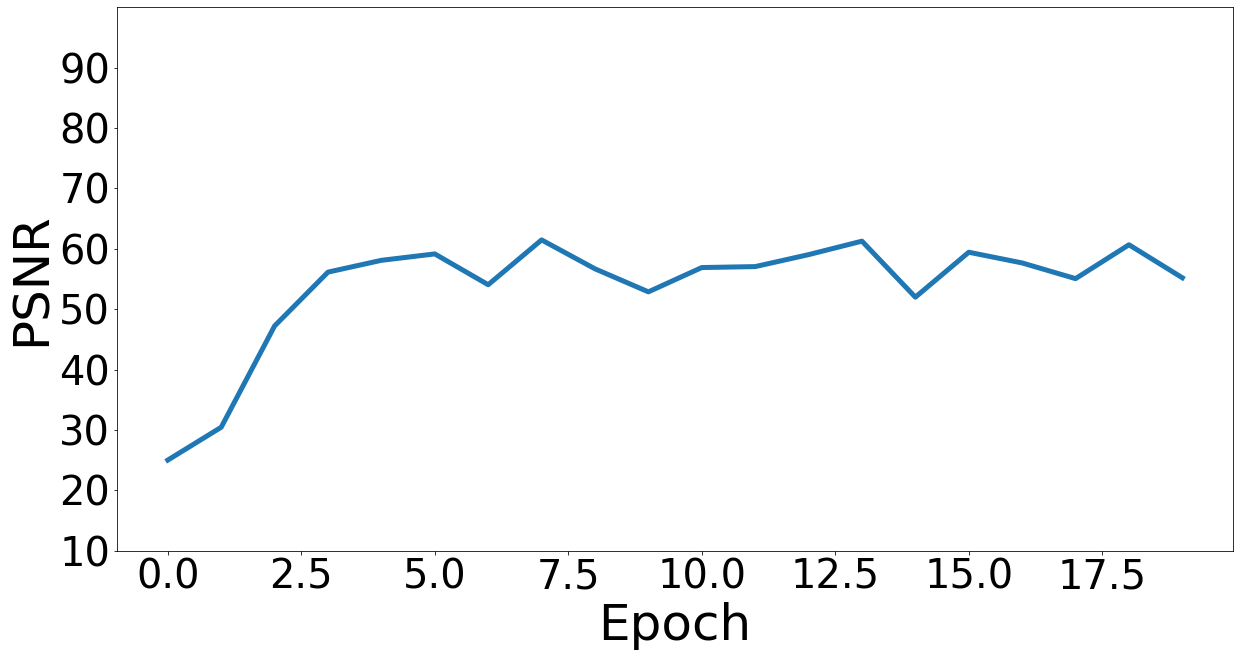

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('PSNR',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(np.arange(0,100 , 10.0),fontsize=40)
plt.ylim(10,100)
plt.plot(x,linewidth=5.0)
plt.savefig('PSNR-SV.pdf')
plt.show()



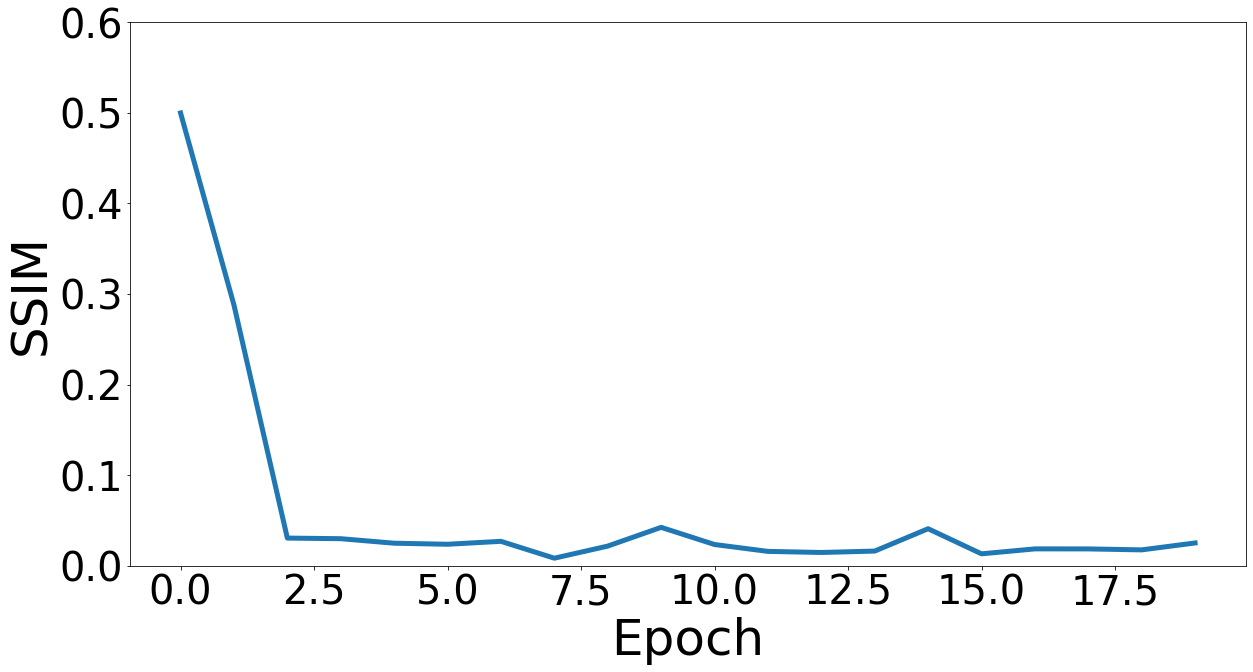

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('SSIM',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.ylim(0,0.6)
plt.plot(xx,linewidth=5.0)
plt.savefig('SSIM-SV.pdf')

plt.show()


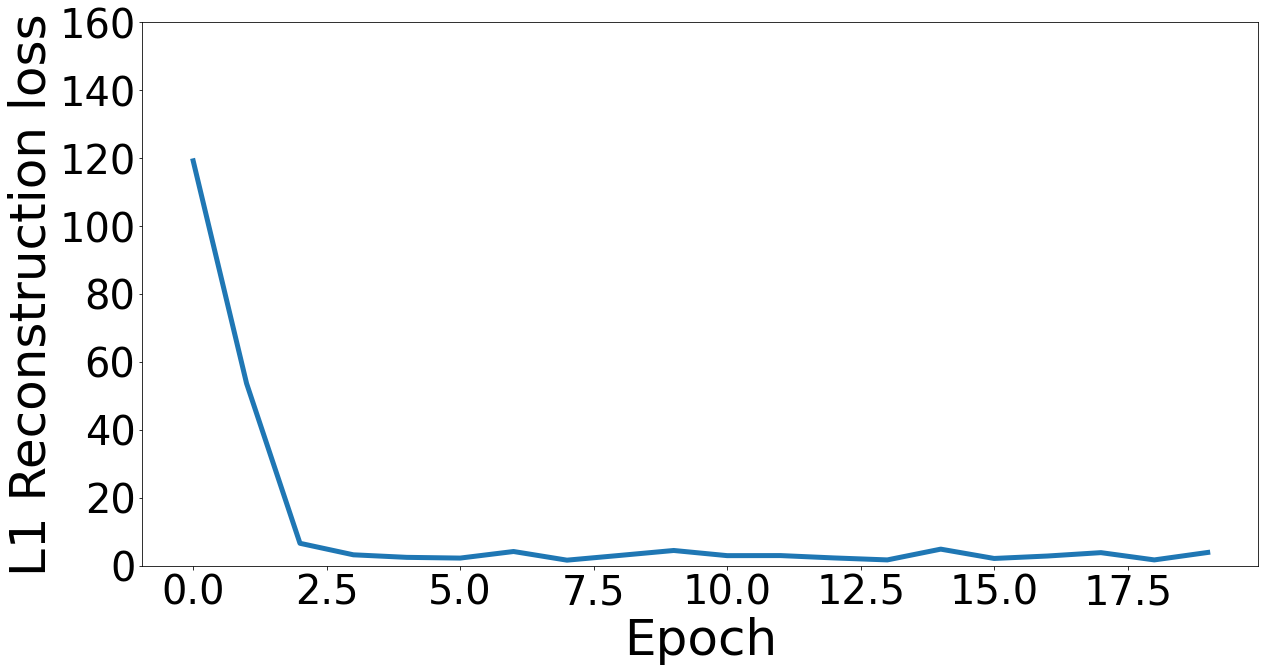

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('L1 Reconstruction loss',fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.ylim(0,160)
plt.plot(xxx,linewidth=5.0)
plt.savefig('L1-SV.pdf')
plt.show()



In [0]:
from google.colab import files
files.download('SSIM-SV.pdf')
files.download('PSNR-SV.pdf')
files.download('L1-SV.pdf')

In [0]:
!wget https://raw.githubusercontent.com/ucalyptus/Double-Branch-Dual-Attention-Mechanism-Network/master/SV.csv

In [0]:
dabsrecnet = [24, 42, 63, 77, 57, 49, 35, 68, 64, 69, 50, 44, 43, 15, 90, 37, 48, 72, 54, 79]
bsnetconv = [116,153,19,189,97,179,171,141,95,144,142,46,104,203,91,18,176,108,150,194]
pca = 	[169,67,168,63,68,78,167,166,165,69,164,163,77,162,70,62,160,161,76,158]
spabs = [0,79,166,80,203,78,77,76,55,81,97,5,23,75,2,82,56,74,143,85] 
snmf = [24,1,105,196,203,0,39,116,38,60,89,104,198,147,158,3,146,4,93,88]
issc = [141,182,106,147,107,146,108,202,203,109,145,148,112,201,110,113,144,149,105,154]


In [0]:
def MeanSpectralDivergence(band_subset):

  n_row, n_column, n_band = band_subset.shape
  N = n_row * n_column
  hist = []
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-20
    # entropy_lst = entropy(hist.transpose())
  info_div = 0
    # band_subset[np.nonzero(band_subset <= 0)] = 1e-20
  for b_i in range(n_band):
    for b_j in range(n_band):
      band_i = hist[b_i].reshape(-1)/np.sum(hist[b_i])
      band_j = hist[b_j].reshape(-1)/np.sum(hist[b_j])
      entr_ij = entropy(band_i, band_j)
      entr_ji = entropy(band_j, band_i)
      entr_sum = entr_ij + entr_ji
      info_div += entr_sum
  msd = info_div * 2 / (n_band * (n_band - 1))
  return msd


In [0]:
def MeanSpectralAngle(band_subset):
    """
    Spectral Angle (SA) is defined as the angle between two bands.
    We use Mean SA (MSA) to quantify the redundancy among a band set.
    i-th band B_i, and j-th band B_j,
    SA = arccos [B_i^T * B_j / ||B_i|| * ||B_j||]
    MSA = 2/n*(n-1) * sum(SA_ij)
    Ref:
    [1]	GONG MAOGUO, ZHANG MINGYANG, YUAN YUAN. Unsupervised Band Selection Based on Evolutionary Multiobjective
    Optimization for Hyperspectral Images [J]. IEEE Transactions on Geoscience and Remote Sensing, 2016, 54(1): 544-57.
    :param band_subset: with shape (n_row, n_clm, n_band)
    :return:
    """
    n_row, n_column, n_band = band_subset.shape
    spectral_angle = 0
    for i in range(n_band):
        for j in range(n_band):
            band_i = band_subset[i].reshape(-1)
            band_j = band_subset[j].reshape(-1)
            lower = np.sum(band_i ** 2) ** 0.5 * np.sum(band_j ** 2) ** 0.5
            higher = np.dot(band_i, band_j)
            if higher / lower > 1.:
                angle_ij = np.arccos(1. - 1e-16)
                # print('1-higher-lower', higher - lower)
            # elif higher / lower < -1.:
            #     angle_ij = np.arccos(1e-8 - 1.)
                # print('2-higher-lower', higher - lower)
            else:
                angle_ij = np.arccos(higher / lower)
            spectral_angle += angle_ij
    msa = spectral_angle * 2 / (n_band * (n_band - 1))
    return msa

In [0]:
def MSA(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralAngle(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    

MSA(dabsrecnet)
MSA(bsnetconv)
MSA(pca)
MSA(spabs)
MSA(snmf)
MSA(issc)




In [0]:
def MSD(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(MeanSpectralDivergence(band_subset),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    

MSD(dabsrecnet)
MSD(bsnetconv)
MSD(pca)
MSD(spabs)
MSD(snmf)
MSD(issc)




In [0]:
import skimage
from skimage import measure
def sumentr(band_subset,X):
  nbands = len(band_subset)
  ENTROPY=np.ones(nbands)
  for i in range(0,len(band_subset)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(X[:,:,band_subset[i]])
  return np.sum(ENTROPY)

 

In [0]:
def EntropySum(bsnlist):
  X, _ = loadData()
  print('[',end=" ")
  for a in range(2,len(bsnlist)):
    band_subset_list = []
    for i in bsnlist[:a]:
      band_subset_list.append(X[:,:,i])     
    band_subset = np.array(band_subset_list)
    band_subset = np.stack(band_subset,axis =2)
    print(sumentr(bsnlist[:a],X),end=" ")
    if a!= len(bsnlist)-1:
      print(",",end=" ")
  print(']')
    
EntropySum(dabsrecnet)
EntropySum(bsnetconv)
EntropySum(pca)
EntropySum(spabs)
EntropySum(snmf)
EntropySum(issc)



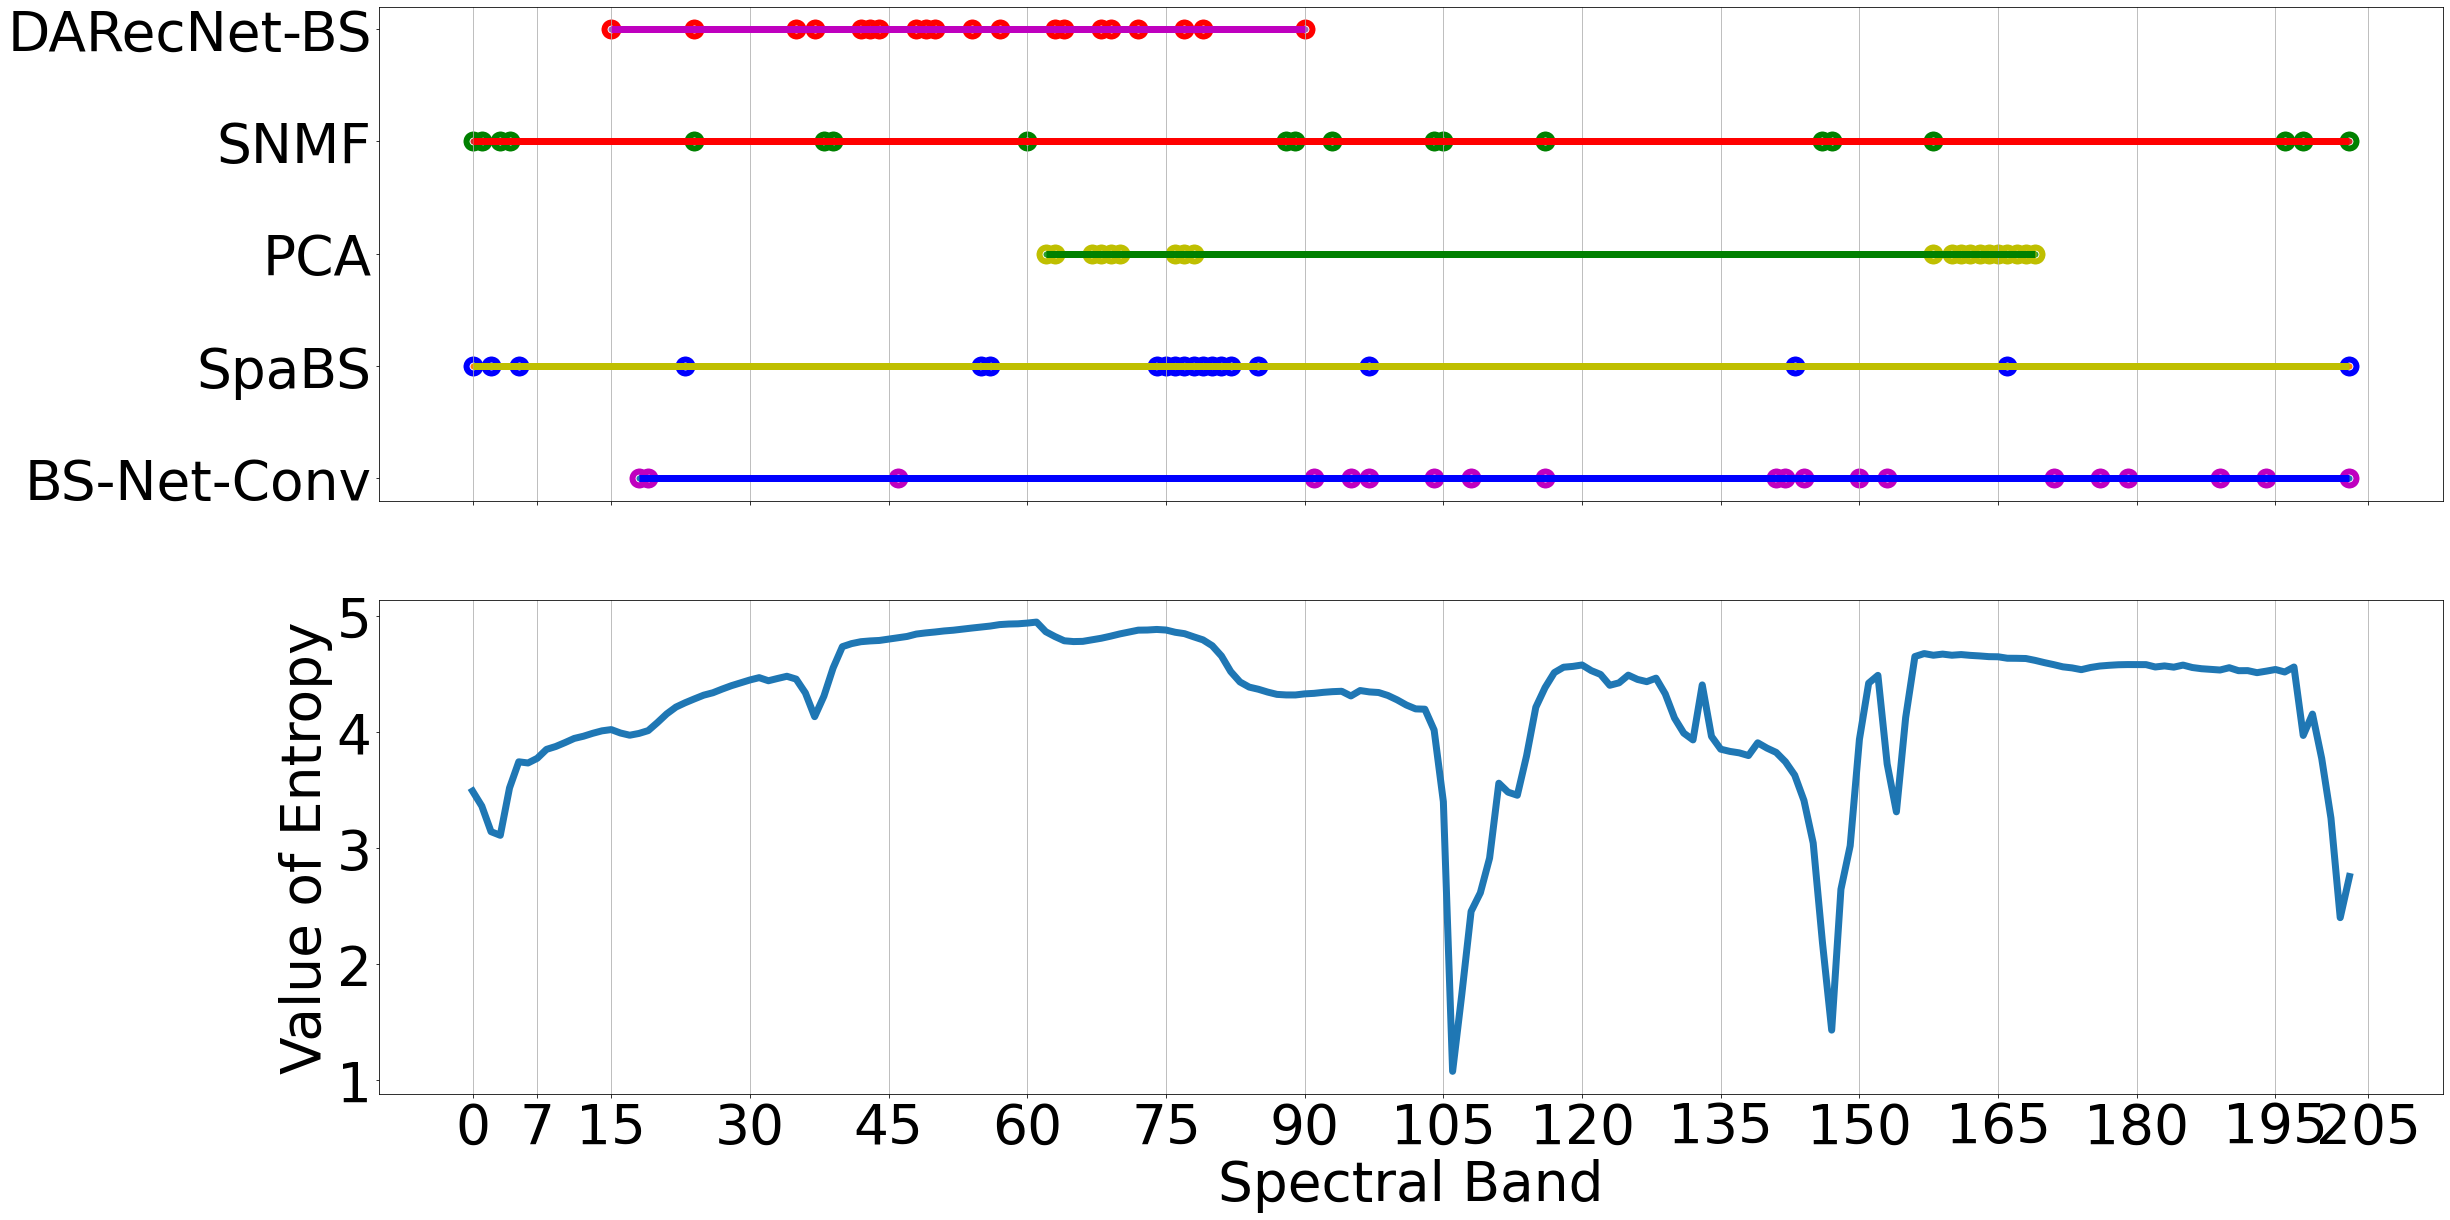

In [0]:
if not (os.path.isfile('/content/SV.csv')):
  !wget https://raw.githubusercontent.com/ucalyptus/Double-Branch-Dual-Attention-Mechanism-Network/master/SV.csv
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("/content/SV.csv")
import matplotlib.pyplot as plt
X, _ = loadData()
n_row,n_column,n_band= X.shape
N = n_row * n_column
hist = []
Entropy  = []
for i in range(n_band):
  hist_, _ = np.histogram(X[:, :, i], 256)
  hist.append(hist_ / N)
  band_i = hist[i].reshape(-1)/np.sum(hist[i])
  entr_i = entropy(band_i)
  Entropy.append(entr_i)
 
for i in range(0,len(df['Selected Bands'])):
  df['Selected Bands'][i] = re.findall('[0-9]+', df['Selected Bands'][i])
  df['Selected Bands'][i] = [int(k) for k in df['Selected Bands'][i]]
meth = ["BS-Net-Conv","SpaBS","PCA","SNMF","DARecNet-BS"]
cols = ['b','y','g','r','m']
fig1,(ax1,ax2) = plt.subplots(2,sharex='col',figsize=(37,20))
ax1.grid(True)
ax1.yaxis.grid(False)
ax1.set_xticks([0,7,15,30,45,60,75,90,105,120,135,150,165,180,195,205])
ax1.yaxis.set_tick_params(labelsize=55)
plt.ylabel(meth)
scatar = []
for i in range(0,len(meth)):
  ax1.hlines(y = meth[i],xmin=min(df['Selected Bands'][i]),xmax=max(df['Selected Bands'][i]),colors=cols[i],linewidth=7)
  SCATTER = ax1.scatter(x=df['Selected Bands'][i],y = [i]*20,edgecolors=cols[i-1],linewidths=14)
  scatar.append(SCATTER)
ax2.grid(True)
ax2.yaxis.grid(False)
ax2.set_yticks([1,2,3,4,5])
ax2.set_ylabel("Value of Entropy",fontsize=55)
ax2.set_xlabel("Spectral Band",fontsize=55)
ax2.xaxis.set_tick_params(labelsize=55)
ax2.yaxis.set_tick_params(labelsize=55)
ax2.plot(Entropy,linewidth=7)
plt.savefig('Entropy_SV.pdf')

